In [1]:
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Flatten, Input 
from keras.layers import Conv2D, MaxPooling2D
from keras.losses import BinaryCrossentropy
from keras.metrics import BinaryAccuracy
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import numpy as np
import cv2
from scipy.signal import convolve2d
import seaborn as sns
from glob import glob
import pandas as pd
from PIL import Image
import numpy as np

# all unhealthy images are named as alternaria
healthy_images = glob('/kaggle/input/mangos-dataset/dataset/healthy/*')
unhealthy_images = glob('/kaggle/input/mangos-dataset/dataset/unhealthy/*')
labels=pd.Series(np.array(['healthy' for i in range(208)]+['unhealthy' for i in range(170)]))

#### preprocessing all input images to grayscale (224,224) dimension and one hot encoding labels

In [2]:
images=[]
for i in range(208):
    images.append(np.array(Image.open(healthy_images[i]).convert('L')))
for i in range(170):
    images.append(np.array(Image.open(unhealthy_images[i]).convert('L')))
images=np.array(images)
labels=pd.get_dummies(labels)

#### train test split

In [3]:
X_train,X_test,Y_train,Y_test=train_test_split(images,labels,train_size=0.8)

#### model will take (224,224) dimension grayscale image as input , which makes feature maps visualization easy , and will have only 5 filters in one convolutional layer , else multiple layers and RGB three channel images hinder visualization ability due to higher dimensions so we have avoided that

In [4]:
model = Sequential()
model.add(Input((224,224,1)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [5]:
model.fit(X_train, Y_train,validation_data=(X_test, Y_test))

10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.4886 - loss: 214.6117 - val_accuracy: 0.7632 - val_loss: 0.6265


##### input image

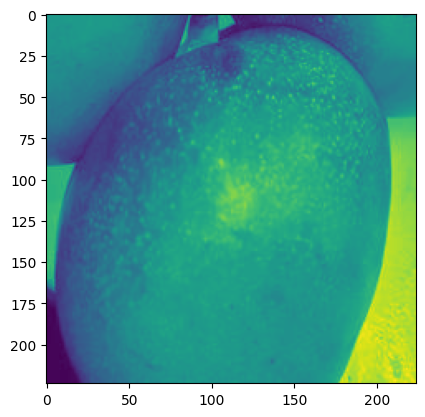

In [6]:
import matplotlib.pyplot as plt
plt.imshow(X_train[0])

# Feature Map Visualization
### Layer 0

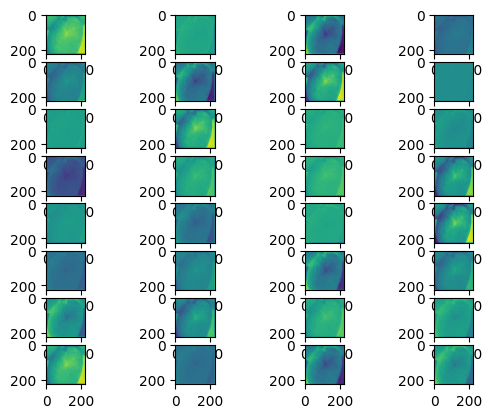

In [7]:
import matplotlib.pyplot as plt
filters, biases = model.layers[0].get_weights()
img=X_train[0]
# normalize filter values to 0-1 so we can visualize them
for i in range(32):
    plt.subplot(8,4,i+1)
    plt.imshow(convolve2d(filters[:,:,0,i],img))

In [8]:
model.layers[0].weights

[<KerasVariable shape=(3, 3, 1, 32), dtype=float32, path=sequential/conv2d/kernel>,
 <KerasVariable shape=(32,), dtype=float32, path=sequential/conv2d/bias>]

### layer 0 has 32 masks of (3,3) which take one input image of (224,224) and return 32 images of (222,222) , which are taken by layer 1 of MaxPooling using (2,2) mask

# Gradient ascent visualization

/tmp/ipykernel_17/1755316952.py:21: RuntimeWarning: invalid value encountered in divide
  gradients = loss-prevloss/img-prevImg


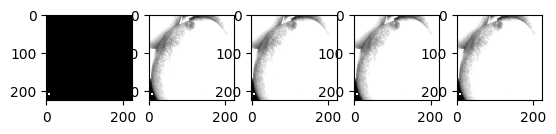

In [9]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.losses import MeanSquaredError
from scipy.signal import convolve2d

def visualize_layer_filter_using_gradient_ascent(model, img_array, layer_number, filter_index, iterations=5, step_size=0.01):

    # Get the filter weights
    filter_weights = model.layers[layer_number].get_weights()[0][:, :, 0, filter_index]

    # Initialize the input image
    img = img_array.astype('float')
    prevloss=np.zeros(shape=img_array.shape,dtype='float')
    prevImg=np.zeros(shape=img_array.shape,dtype='float')
    # Perform gradient ascent
    for i in range(iterations):
        # Compute the gradient of the loss with respect to the input image
        target=np.ones(shape=img_array.shape,dtype='float')
        loss=target-img
        gradients = loss-prevloss/img-prevImg
        # Update the image
        prevImg=img
        prevloss=loss
        img+=(gradients*step_size)
        img = tf.clip_by_value(img, 0, 1)  # Ensure pixel values are within valid range
        plt.subplot(1,5,i+1)
        plt.imshow(img, cmap='gray')
    return img


# Assuming 'model' and 'img' are defined elsewhere
visualized_img = visualize_layer_filter_using_gradient_ascent(model, img, layer_number=2, filter_index=31).numpy()


# Display the visualized image

plt.show()